In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lets_plot import *

In [6]:
from datalore.display import *

In [7]:
from scipy.stats import uniform, norm, geom, mannwhitneyu, ks_2samp
from scipy.linalg import cholesky

In [8]:
from copy import copy
import time

In [9]:
from PIL import Image

In [10]:
import seaborn as sns

In [11]:
def square_loss(y, X, beta):
    r = y - X.dot(beta)
    return (r**2).sum()

In [12]:
def eval_score(model, val, y_val):
    y_hat = model(val).squeeze()
    y_val = y_val.squeeze()
    return 1. - ((y_val-y_hat)**2).mean()/np.var(y_val)

In [13]:
def clip(x, min_x, max_x):
    x_ = copy(x)
    x_[x_ < min_x] = min_x
    x_[x_ > max_x] = max_x
    return x_

In [14]:
def plot_map(data, zoom=6, legend=True):
    plot = ggplot(data=data)\
        + geom_livemap(zoom=zoom)\
        + geom_point(mapping=aes(x='Longitude',
                                 y='Latitude', 
                                 color='target'),alpha=0.1)\
        + scale_color_gradient(low='blue', high='red') + ggsize(500, 500)
    if not legend:
        plot += theme(axis_text='blank', axis_ticks='blank', axis_line='blank', axis_title='blank', legend_position='none')
    return plot

# Problem 1 (0.5)
Taking some non-linear function $g$ you can transform any given distribution to another distribution with non-trivial form.
Let's start from normally distributed value $z$. Suppose $z\in\mathbb{R}^2$, consider the function $\displaystyle g(z)=C\frac{z}{\|z\|_{\alpha}}+\frac{z}{s}$.
$\color{blue}{\text{Fill in the implementation of the function}}$ `g(z, C, ord, scale)` $\color{blue}{\text{below.}}$

In [15]:
def g(z, C=2.5, ord=2, scale=10):
    """
Args: 
  z - function argument
  C - first scalling constant
  ord - norm order defined as alpha
  scale - second scalling coefficient
Returns:
  vectorized resulting value
"""
    # YOUR CODE (START)
    result = C * z / np.linalg.norm(z, ord=ord) + z / scale
    # YOUR CODE (END)
    return result

In [16]:
x = np.random.normal(loc=0, scale=1, size=(1000, 2))
y = g(x, ord=np.inf)
data = pd.DataFrame(x, columns=['x1', 'x2'])
data['y1'], data['y2'] = y[:,0], y[:,1]

In [17]:
ggplot(data) \
        + geom_point(aes(x='x1', y='x2'), color='blue') \
        + geom_point(aes(x='y1', y='y2'), color='red') \
        + ylim(-3,3) + xlim(-3,3)

# Problem 2 (0.5)

##### The Multivariate Normal Distribution
Let $z_1,\ldots,z_m\sim N(0,1)$, $Z=(z_1,\ldots,z_m)$, define constants $a_{ij}$, $i=1,\ldots,n$, $j=1,\ldots,m$ and $\mu_i$, $i=1,\ldots,n$, and let 

$\displaystyle{
\begin{array}{l}
x_1=a_{11}z_1+a_{12}z_2+\cdots+a_{1m}z_m+\mu_1\\
\cdots\\
x_i=a_{i1}z_1+a_{i2}z_2+\cdots+a_{im}z_m+\mu_i\\
\cdots\\
x_n=a_{n1}z_1+a_{n2}z_2+\cdots+a_{nm}z_m+\mu_n\\
\end{array}}$

then random vector $X=(x_1,\ldots,x_n)$ is said to have a multivariate normal distribution

##### Moments of multivariate normal distribution
Let's write down the moments of $X$: 
* $\displaystyle{\mathbb{E}X=\mathbf{\mu}=(\mu_1,\ldots,\mu_n)}$
* $\displaystyle{\mathrm{cov}(x_i,x_j)=\sum_{k=1}^ma_{ik}a_{jk}}$

##### Generating covariance matrix

Covariance matrix $\displaystyle{P\in \mathbb{R}^{n\times n}}$ can be generated in two steps

* Generate random $\displaystyle{S\in \mathbb{R}^{k\times n}}$, for $k>m$;

* Take $\displaystyle{P=S^TS}$

$\color{blue}{\text{Fill in the implementation of }}$ `generate_cov` $\color{blue}{\text{function below. Generate random matrix using}}$ `np.random.uniform` $\color{blue}{\text{function.}}$

In [18]:
def generate_cov(k, n=2):
    """ Generates covariance matrix
Args:
    k - the first dimension of the matrix S
    n - the dimention of the covariance matrix
Returns:
    P - covariance matrix

"""
    P = np.eye(n)
    # YOUR CODE (START)
    S = np.random.uniform(size=(k, n))
    P = S.T @ S
    # YOUR CODE (END)
    return P

In [19]:
# generate covariance matrix
P = generate_cov(3, 2)
# check eigenvalues
print(f'eigenvalues: {np.linalg.eigvals(P)}')

eigenvalues: [1.22491123 0.23582253]


# Problem 3 (0.5)
Denote $A=\{a_{ij}\}\in \mathbb{R}^{n\times m}$ and write an expression for $X$ in a vector form: $\displaystyle \boxed{\;X^T=AZ^T+\mu^T\;}$

So, the covariance matrix $C=AA^T$ and we can get $A$ from $C$ via Cholesky decomposition.


In [20]:
# get Cholesky decomposition for the matrix P
L = cholesky(P, lower=True)
# check that multiplying L back gives us matrix P again 
print(f'L multiplied by L transposed:\n {np.dot(L, L.T)}')
print(f'P: \n {P}')

L multiplied by L transposed:
 [[0.76708446 0.49317941]
 [0.49317941 0.6936493 ]]
P: 
 [[0.76708446 0.49317941]
 [0.49317941 0.6936493 ]]


In [21]:
n = 2
A = cholesky(P, lower=True)
mu = np.ones(n)

$\color{blue}{\text{Fill in the implementation of }}$ `mvn(A, mu)` $\color{blue}{\text{function below generating multivariate normal values according to the formula}}$
$$\displaystyle \boxed{\;X^T=AZ^T+\mu^T\;}$$

In [22]:
def mvn(A, mu, size):
    """Generates multivariate normal variables
Args:
    A - coefficient matrix
    mu - mean value vector
    size - number of values to generate 
Returns:
    X - matrix with multivariate normal values
"""
    X = np.random.uniform(size=(2, size))
    # YOUR CODE (START)
    Z = np.random.normal(size=(size, 2))
    X = A @ Z.T + mu.reshape(-1, 1)
    # YOUR CODE (END)
    return X

In [23]:
# generate multivcariate normal variables
X = mvn(A, mu, size=1000)

In [24]:
import warnings

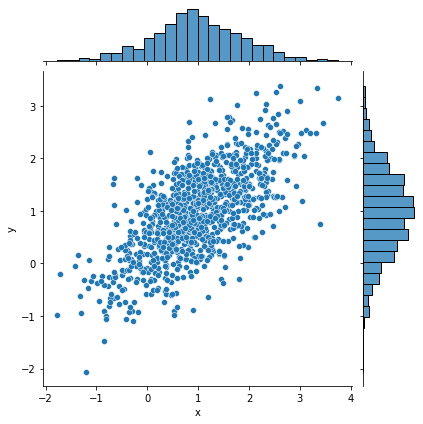

In [25]:
warnings.filterwarnings("ignore")
# this is some scipy issue actually
df = pd.DataFrame(X.T)
df.columns = ['x', 'y']
sns.jointplot(x=df['x'], y=df['y'], kind='scatter');

# Problem 4 (0.5)

Consider random matrix $S$ with elements sampled from the uniform $U[-1,1]$ distribution. What should be done with the elements of $S$ in order to get eigenvalues of $S$ to be inside the ball with radius 1? (See Eigendecomposition section in the Lecture 01.01)

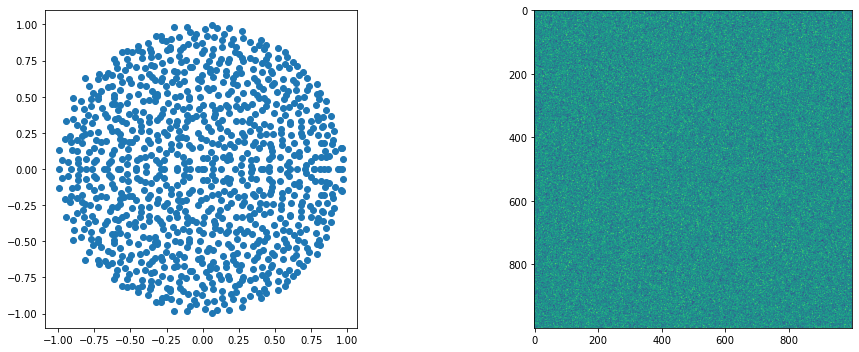

In [26]:
n = 1000
S = np.random.uniform(-1, 1, size=(n, n))
S = (S - np.mean(S)) / np.sqrt(n) / np.std(S)
a = np.linalg.eigvals(S)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].scatter(np.real(a), np.imag(a))
axes[0].set_aspect(1)
axes[1].imshow(S)
fig.tight_layout()

# Smirnov's Theorem
Let $\eta$ be a continuous r. v. with a c.d.f. $F$.

Define inverse function: $G(u)=\inf \{x: F(x)\geq u\}$,  $0 < u < 1$  inverse function for $F$: $ F(G(x))=x$,  $0<x<1$.

What is the distribution of r.v. $\xi = F(\eta)$? 
Notice, that $ 0\leq \xi\leq 1$. 
Derive the c.d.f. of $\xi$:

$H(x)=\pr\left(\xi\leq x\right)=\pr\left(F(\eta)\leq x\right)=\pr\left(\eta \leq G(x)\right)=F(G(x))=x,\quad 0<x<1 \quad \Rightarrow\quad \xi \sim U_{[0,1]}$.

How this can be used for modeling? 
Let $\xi \sim U_{[0,1]}$ and $G=F^{-1}$ - inverse for some c.d.f., then $\eta=G(\xi)\sim F$.

#### Empirical distribution
Suppose we have observations $x^{(1)}, \ldots,x^{(m)}$ from some probability distribution with cumulative distribution $F(x)$. We can define empirical distribution on the observed values $x^{(1)}, \ldots,x^{(m)}$
$$\hat{F}_m(x)=\frac{1}{m}\sum_{i=1}^m 1_{\{x^{(i)}\leq x\}}$$

# Problem 5 (0.5)
$\color{blue}{\text{Fill in the implementation of the function}}$ `cdf_xy(observations)` $\color{blue}{\text{which returns x and y coordinates for an empirical function built from observations.}}$

In [27]:
def cdf_xy(values):
    x, y = np.sort(np.random.uniform(size=len(values))), np.sort(np.random.uniform(size=len(values)))
    # YOUR CODE (START)
    x = np.sort(np.unique(values))
    y = np.sum(x.reshape(-1, 1) > values, axis=0) / values.shape[0]
    # YOUR CODE (END)
    return x, y

In [28]:
observations = np.random.normal(size=1000)

Now we can get $x$ and $y$ coordinates of the empirical function $\hat{F}_m(x)$ and construct an interpolation $\tilde{F}_m(x)$ with `np.interp` function and apply the resulting interpolated function to some distribution to get flattened version of it. We already know, what happens to normal distribution:

In [29]:
x, y = cdf_xy(observations)
equalized_dist = np.interp(observations, x, y)

In [30]:
data = pd.DataFrame({'x':x, 'y':y})

In [31]:
bunch = GGBunch()
plot = ggplot() + geom_histogram(aes(equalized_dist, y='..density..'), fill='blue', alpha=0.5, bins=50) + geom_histogram(aes(observations, y='..density..'), fill='red', alpha=0.5) + ggsize(400, 300) + ggtitle('Initial and flattened distributions')
bunch.add_plot(plot, 0, 0)
plot = ggplot(data) + geom_path(aes('x', 'y'), color='blue', size=1) + ggsize(400, 300) + ggtitle('Interpolated empirical cdf')
bunch.add_plot(plot, 400, 0)
bunch.show()

We can treat an image (flattened to a vector) as some "distribution" and apply the same technique to it. This approach is called "image equalization".

In [32]:
colored_image = np.array(Image.open("gateway.jpg"))
image = np.mean(colored_image, axis=2)/255
image_data = image


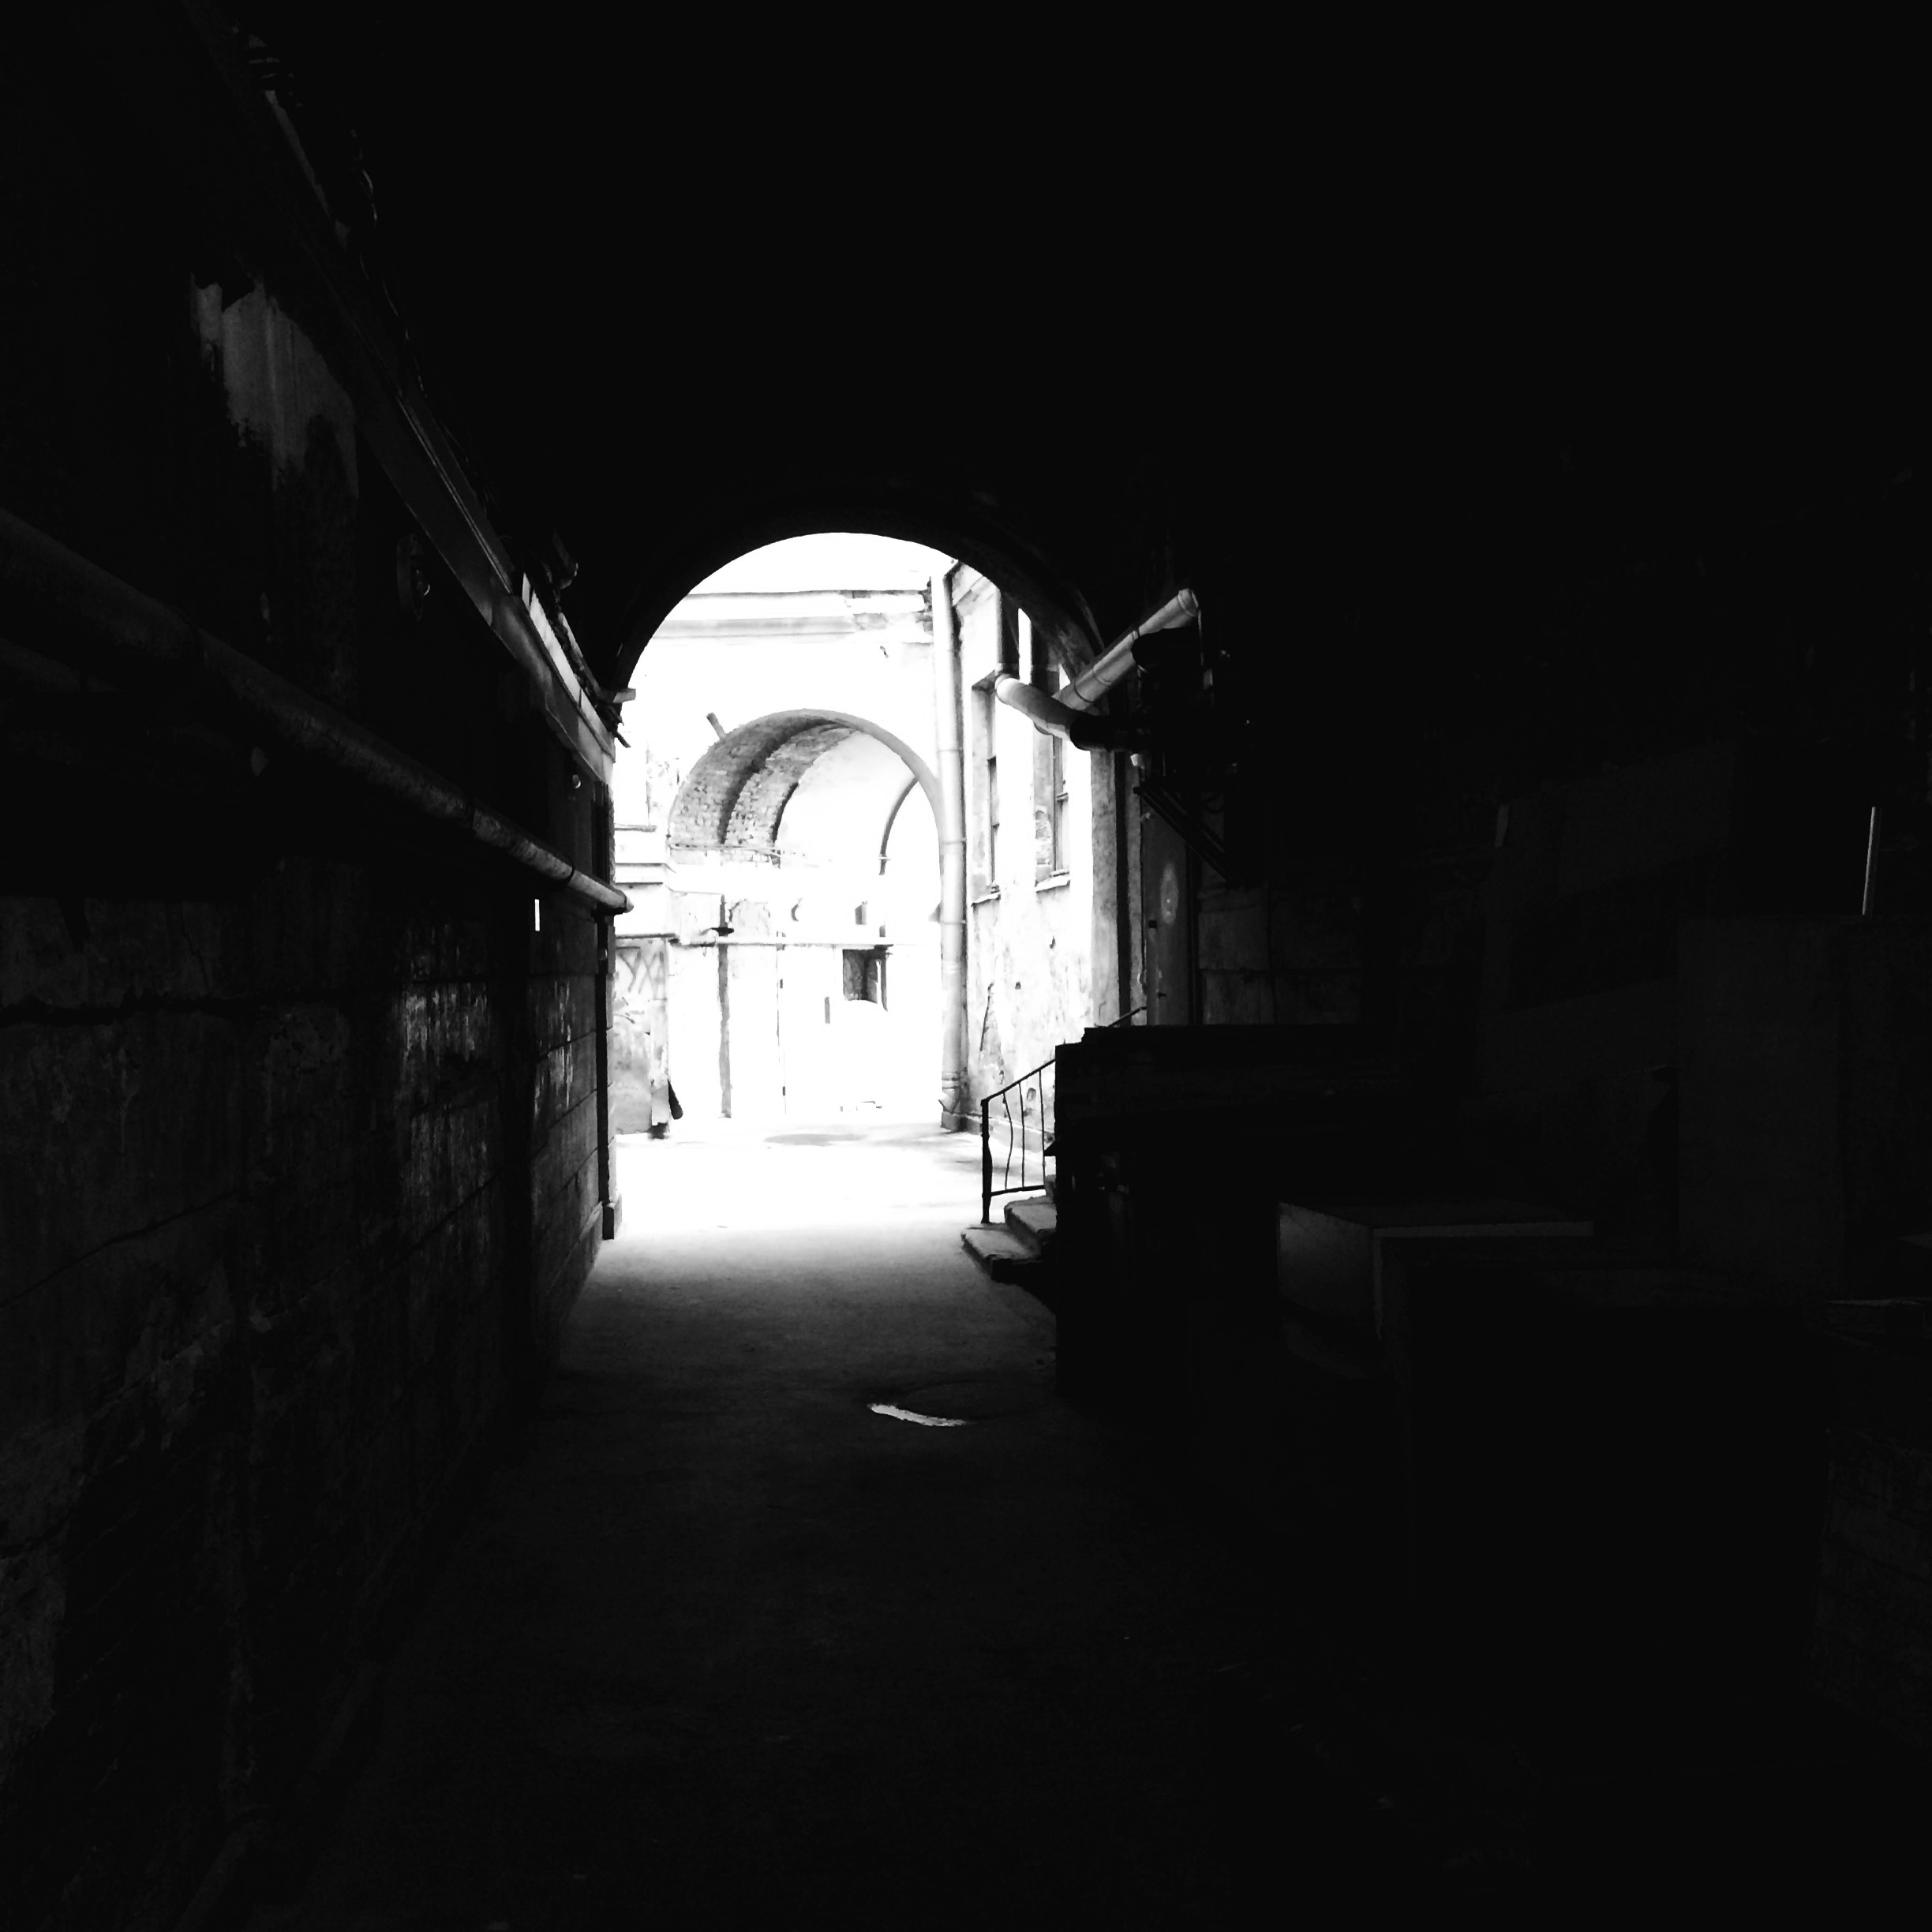

In [33]:
ggplot() + geom_image(image_data) + theme(legend_position='none', axis_ticks='blank', axis_line='blank', axis_title='blank', axis_text='blank') + ggtitle('Initial image')

In [33]:
flat = image.reshape(-1)
x, y = cdf_xy(flat)
equalized_image = np.interp(image, x, y)

In [34]:
ggplot() + geom_image(image_data=equalized_image) + theme(legend_position='none', axis_ticks='blank', axis_line='blank', axis_title='blank', axis_text='blank') + ggtitle('Equalized image')

# Problem 6 (1.0)
In this task we will solve linear regression problem with the help of batch gradient descent. We will build our model in a way similar to what is usually done in deep learning frameworks (like PyTorch or TensorFlow), which perform differentiation automatically. The main difference here will be that you'll implement the differentiation part writing formulas by yourself.

First, we read California housing data from the [StatLib repository](http://lib.stat.cmu.edu/datasets/) and saved it to a file.
Then we read data to a data frame and define feature matrix $X$ and target vector $y$. **Features** contain coordinates (lat, lon), house age, number of rooms, number of bedrooms, population in the area, number of households and average income. **Target** value is a log-cost of a house. We are going to build a model, which will predict the house cost by it's features.

In [35]:
class fetch_california_housing:
    def __init__(self, filename='cal_housing.data', scale_target=True):
        filedata = pd.read_csv(filename, header=None).values
        self.data = filedata[:, :-1]
        self.target = filedata[:,-1]
        if scale_target:
            self.target = self.target / 100000
        self.feature_names = ['Longitude',
                      'Latitude',
                      'housingMedianAge',
                      'totalRooms',
                      'totalBedrooms',
                      'population',
                      'households',
                      'medianIncome']

In [36]:
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['target'] = housing.target

In [37]:
X, y = housing.data, housing.target

We also removed the tail observations, containing house costs clipped to a value of 5 to avoid atoms in our distribution.

In [38]:
# remove tail observations clipped to the value 5
what_to_stay = (y < 5)
X, y = X[what_to_stay], y[what_to_stay]

Define the linear transformation coefficients - matrix $W\in\mathbb{R}^{n\times k}$ and vector $b\in\mathbb{R}^{1\times k}$ - parameters of our linear model 
$$y=xW+b$$
where feature vector (observation) $x\in\mathbb{R}^{1\times n}$ and target value $y\in\mathbb{R}^{1\times k}$. In our task $k=1$.

In [39]:
def Linear(in_dim, out_dim):
    W = np.random.normal(loc=0, scale=0.1, size=(in_dim, out_dim))
    b = np.random.normal(loc=0, scale=0.1, size=(1, out_dim))
    return W, b

We also need to determine the way we compute the loss. Mean square loss is a common choice for a regression task.
Note, that we define two necessary methods here: `forward` and `backward`. In `forward` method we describe the function which implements loss computation. In `backward` method we write the derivative of the function, defined in `forward` method.   

In [40]:
class MSELoss:
    def __init__(self, eps=1e-15):
        self.eps = eps

    def forward(self, output, target):
        self.target = target.squeeze()
        self.output = output.squeeze()
        return ((self.target - self.output)**2).mean()

    def backward(self):
        return self.output - self.target

    def __call__(self, output, target):
        return self.forward(output, target)

The optimization technique, which we are going to use is called Stochastic Gradient Descent and the next class implements model parameters updates according to gradient descent rule $\displaystyle \boxed{\;\hat{\theta}_{t+1}=\hat{\theta}_t-\color{blue}\eta\nabla J\;}$ where $\eta$ - is the learning rate.

In [41]:
class SGD:
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate

    def step(self, grads, params, learning_rate=None):
        if learning_rate is None:
            learning_rate = self.learning_rate
        new_parameters = []
        for param, grad in zip(params, grads):
            param -= learning_rate*grad
            new_parameters.append(param)
        return new_parameters

We already found out, that scaling inputs can dramatically increase the convergence speed of gradient descent.

In [42]:
def scale(X):
    X_ = copy(X)
    X_ -= X_.mean(axis=0)
    X_ /= X_.std(axis=0)
    return X_

$\color{red}{\text{Our data should be split into train, validation and test sets. We train our model using train data and validate it during training on validation data. After the model is totally trained we can check the model generalization ability using test data.}}$

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
print('X_train shape: {}, X_val shape: {}, X_test shape: {}'.format(X_train.shape, X_val.shape, X_test.shape))

We'll use batch training, so we need a data loader class, which will feed our training procedure with batches of training data. Note, that we shuffle the data after each training epoch.

In [45]:
class DataLoader:
    def __init__(self, data, target, batch_size=100):
        self.data = data
        self.target = target
        self.batch_size = batch_size

    def next(self):
        m, _ = self.data.shape
        rand_index = np.random.choice(m, size=m)
        X, y = self.data[rand_index], self.target[rand_index]
        pos = 0
        while pos < m:
            X_batch, y_batch = X[pos:pos+self.batch_size], y[pos:pos+self.batch_size]
            yield (X_batch, y_batch)
            pos += self.batch_size

    def __call__(self):
        return self.next()

The next class implements gradient descent linear regression. It also contains `forward` and `backward` methods. In the `forward` method you define the linear transformation $\displaystyle Y=XW+b$, where $X\in\mathbb{R}^{M\times n}$ and $Y\in\mathbb{R}^{M\times k}$, where $M$ stands for a batch size. 
In the `backward` method we return gradients, calculated by a `gradients` method.

$\color{red}{\textbf{NOTE: TASK IS HERE}}$

$\color{blue}{\text{Fill in the implementation of methods}}$ `gradients` $\color{blue}{\text{and}}$ `forward` $\color{blue}{\text{below.}}$

In [46]:
class SGDLinearRegression:
    def __init__(self, in_dim=8, out_dim=1):
        self.W, self.b = Linear(in_dim, out_dim)

    def forward(self, x):
        self.data = x
        # YOUR CODE (START)

        # YOUR CODE (END)
        z = np.zeros(x.shape[0])
        return z

    def gradients(self):
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)
        # YOUR CODE (START)

        # YOUR CODE (END)
        return (dW, db)

    def backward(self, loss_function):
        self.loss_function = loss_function
        return self.gradients()

    def parameters(self):
        return (self.W, self.b)

    def update(self, params):
        self.W, self.b = params

    def __call__(self, x):
        return self.forward(x)

Define the number of epochs rto train your model.

In [47]:
num_epochs = 50

Define dataloader, model, loss function and optimizer instances.

In [48]:
dataloader = DataLoader(X_train, y_train)
model = SGDLinearRegression()
loss_function = MSELoss()
optimizer = SGD()

Create strwam for live plots (will be updated during training).

In [49]:
score_stream = DataPubStream(['epoch', 'score'])
other_options = xlim(0, num_epochs) + ggsize(500, 300) + ggtitle('Validation score')
ggplot(score_stream) + geom_area(aes('epoch','score'), alpha=0.2) + other_options

In [50]:
loss_stream = DataPubStream(['epoch', 'loss'])
other_options = xlim(0, num_epochs) + ggsize(500, 300) + ggtitle('Loss')
ggplot(loss_stream) + geom_area(aes('epoch','loss'), alpha=0.2) + other_options

Here is our main training loop. We repeat calculation `num_epoch` times. During each epoch we read batches of train data from data loader and feed them to our model. Then we put target values and obtained model outputs into our loss function and compute gradients, which are used then to update model parameters. We use validation data to evaulate our model during training.

In [51]:
losses = []
for epoch in range(num_epochs):
    loss_sum = 0
    for data in dataloader():
        inputs, targets = data
        inputs = scale(inputs)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss_sum += loss
        grads = model.backward(loss_function)
        params = model.parameters()
        new_params = optimizer.step(grads, params)
        model.update(new_params)
    score = eval_score(model, scale(X_val), y_val)
    print(f'\r epoch: [{epoch+1}/{num_epochs}], loss: {np.round(loss_sum, 2)}, score: {np.round(score, 2)}', end='')
    score_stream.write([epoch, float(score)])
    time.sleep(0.01)
    loss_stream.write([epoch, float(loss_sum)])
    losses.append(loss_sum)

After the training is finished we can predict targets for unseen examples from the test data set.

In [52]:
y_pred = model(scale(X_test)).squeeze()
y_pred = clip(y_pred, 0, 5)

In [53]:
test_data = pd.DataFrame(X_test, columns=housing.feature_names)
test_data['target'] = y_test
pred_data = pd.DataFrame(X_test, columns=housing.feature_names)
pred_data['target'] = y_pred

Let's plot actual test data and model prediction on a map (we have lat, lon coordinates in our data set).

In [54]:
bunch = GGBunch()
plot = plot_map(test_data, legend=False) + ggtitle('Test data')
bunch.add_plot(plot, 0, 0)
plot = plot_map(pred_data, legend=False) + ggtitle('Predicted test data')
bunch.add_plot(plot, 500, 0)
bunch.show()

In [55]:
target_data = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
target_data = pd.melt(target_data)

We can also compare the empirical densities of actual and predicted data.

In [56]:
ggplot(target_data) \
        + geom_histogram(aes(x='value', y='..density..', group='variable', fill='variable'), alpha=0.4, position='identity') \
        + ggtitle('Actual and predicted target value distributions')

In [57]:
counts_pred, bounds_pred = np.histogram(y_pred)
counts_test, bounds_test = np.histogram(y_test, bounds_pred)

We can use Mann-Whitney and Kolmogrorov-Smirnov tests to evaluate statstical accuracy of our model.

In [58]:
mannwhitneyu(y_test, y_pred, alternative='two-sided')

In [59]:
ks_2samp(y_test, y_pred)

# Problem 7 (1.0)
Consider the Normal distribution: $\xi: N\left(a,\sigma^2 \right)$, then for any random variable $\eta$ having first two moments: $\mathbb{E}\eta=a, \mathbb{D}\eta =\sigma^2$ 
entropy for the Normal variable will be not less than the entropy for $\eta$:  $H\left(\xi\right)\geq H\left(\eta\right)$.
Prove this statement. $\color{red}{\text{Take } a=0 \text{ to simplify the derivation.}}$ 

* Hint: look into lecture notes for examples on Uniform dustribution and Exponential distribution.

#### Solution


#### Convex function
$$\forall x_1, x_2, \forall \lambda\in[0,1]: \; \boxed{\;f(\lambda x_1+(1-\lambda)x_2)\leq \lambda f(x_1)+(1-\lambda)f(x_2)\;}$$
#### Jensen's inequality
Let $f$ be a convex function, then
$$\boxed{\;f\left(\sum_{i=1}^n\lambda_i x_i\right)\leq \sum_{i=1}^n\lambda_i f(x_i)\;}$$
#### Information inequality
$\mathcal{D}_{KL}(p||q)\geq 0$ and equality holds iff $p=q$

# Problem 8 (1.0)
$\color{blue}{\text{Prove the statement of information inequality theorem.}}$

#### Proof:


# Problem 9 (0.5)
#### Regularity conditions
On the lecture we several times used regularity conditions, which made us possible to change the order of integration and differentiation
$$\frac{\partial}{\partial \theta}\int f(\theta,x)dx=\int\frac{\partial}{\partial\theta}f(\theta, x)dx$$
Consider $X\sim U_{[0, \theta]}$ - uniformly distributed on the interval $[0, \theta]$ random variable and $\color{blue}{\text{check, if we can change the order of integration and differentiation in this case.}}$
$\color{red}{\text{NOTE:}}$ $f(\theta,x)$ here is a density function of $X$

#### Solution

### Inclusive KL-divergence

$$\mathcal{D}_{KL}(p ||q_{\theta})=\int p(x)\log\frac{p(x)}{q_{\theta}(x)}dx$$

### Exclusive KL-divergence

$$\mathcal{D}_{KL}(q_{\theta}||p)=\int q_{\theta}(x)\log\frac{q_{\theta}(x)}{p(x)}dx$$

# Problem 10 (0.5)

Suppose $P$ is a binomial distribution $B(p, n)$ and $Q=B(n,q)$. What is the Kullback-Leibler divergence between P and Q?

#### Solution
$$
\mathcal{D}_{KL}\Big(P \;\|\ \; Q \Big) = 
$$

# Problem 11 (1.0)

Explain the difference in minimization of inclusive versus exclusive KL-divergence.

### Solution

### Due date is $\color{blue}{17}$ of February 2021 23:59:59

### Instructions
* To submit the assignment share your workbook to me (can edit option). Make sure that you provide me "Can edit" access.

* Check, that you found all the tasks in the workbook.  